<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Air-Quality-Prediction-LSTM-RNN%20(Time%20Series)/Air_Quality_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset & Setup Project

In [32]:
#------------------#
# Download Dataset #
#------------------#
import kagglehub

path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")
print("Path to dataset files:", path)

#------------------#
# Import Libraries #
#------------------#
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from datetime import datetime
import logging
import warnings

#-----------------#
# Loading Dataset #
#-----------------#
df = pd.read_csv("/kaggle/input/air-quality-data-in-india/city_hour.csv")
df.head(5)

#-----------#
# Setup Env #
#-----------#
warnings.filterwarnings('ignore')
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.DEBUG,
    handlers=[
        logging.FileHandler('air_quality.log'),
        logging.StreamHandler()
    ])

logger = logging.getLogger(__name__)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Path to dataset files: /kaggle/input/air-quality-data-in-india


In [33]:
df.head(5)

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN


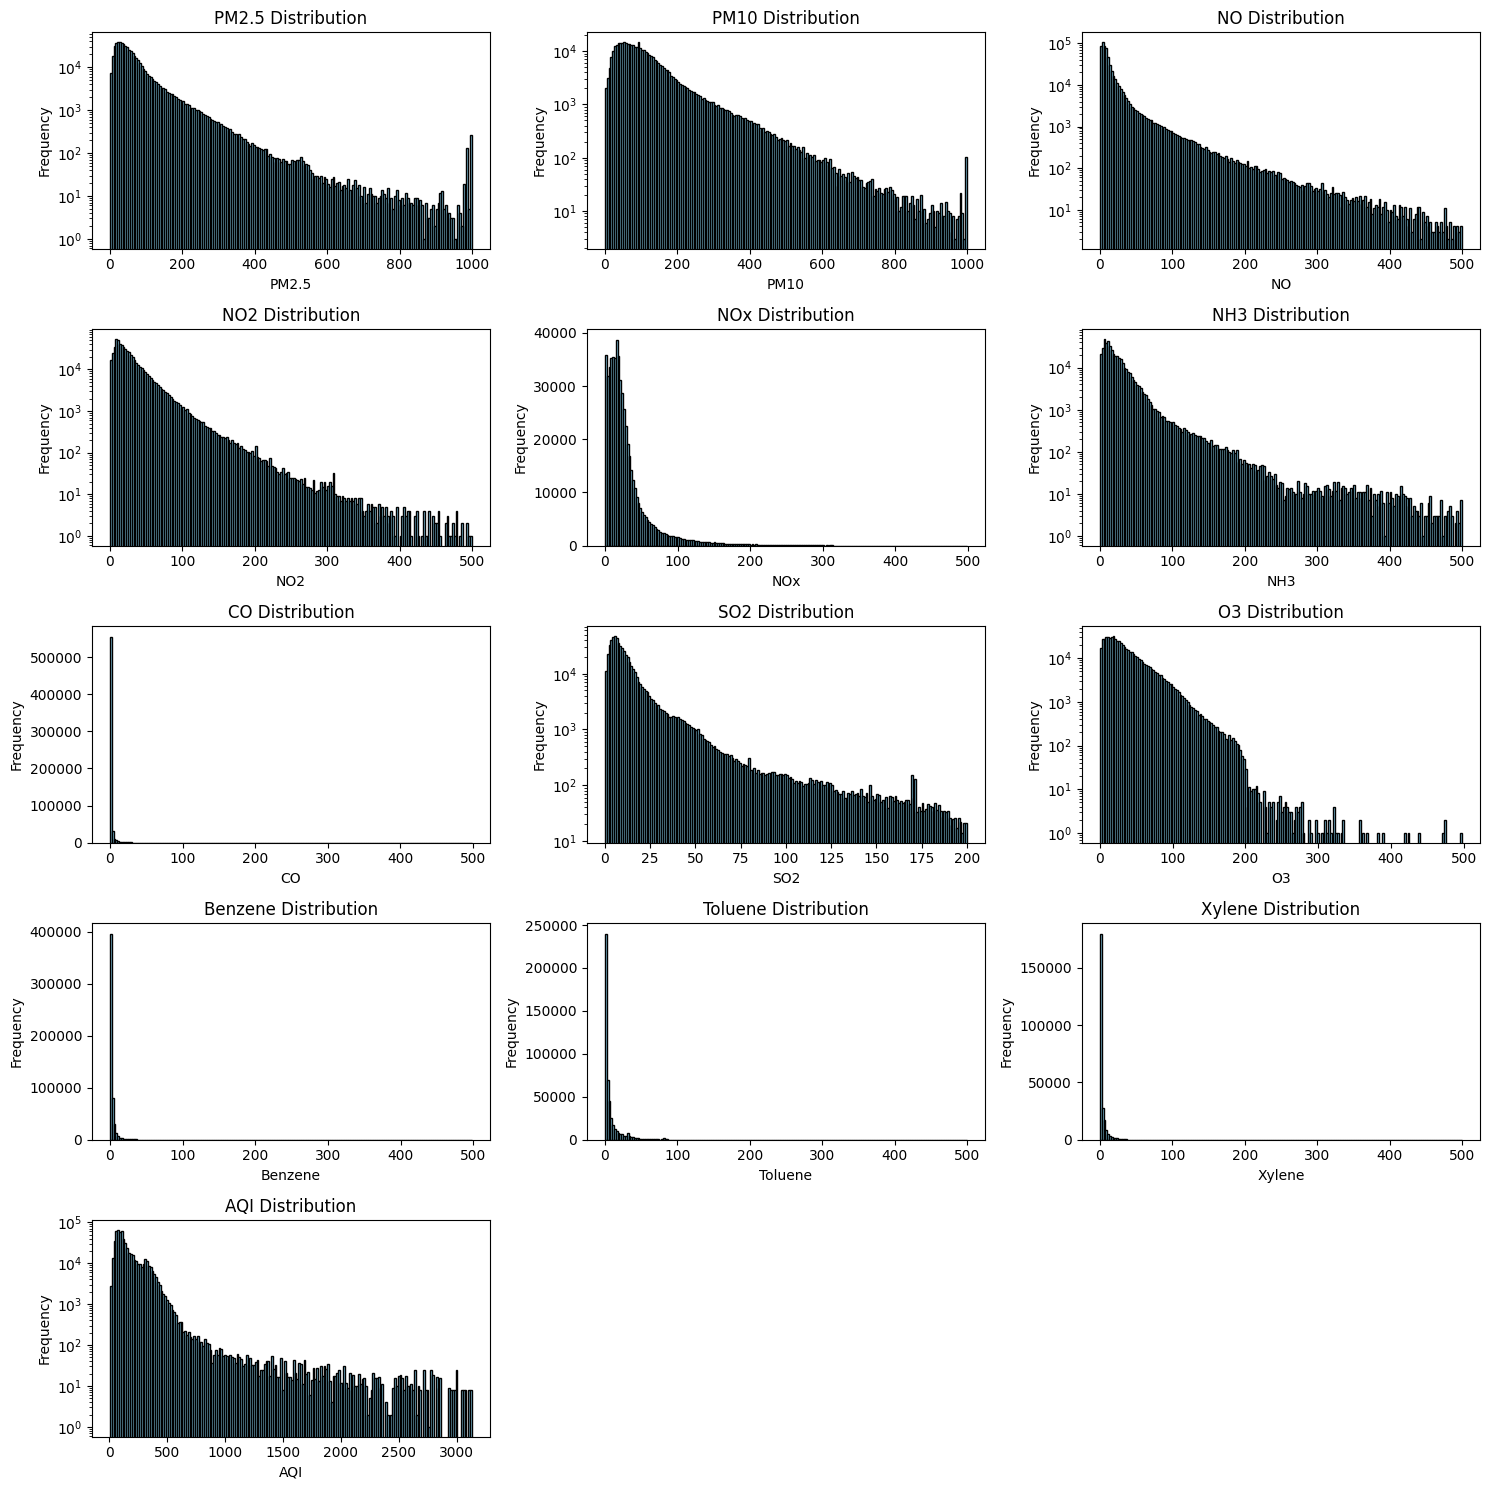

In [34]:
numeric_cols = df.select_dtypes(include='number').columns
n_cols = len(numeric_cols)
n_cols_per_row = 3
n_rows = (n_cols + n_cols_per_row - 1) // n_cols_per_row

plt.figure(figsize=(15, 3 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols_per_row, i)
    data = df[col].dropna()
    if data.min() <= 0:
        plt.hist(data, bins=200, color='skyblue', edgecolor='black')
    else:
        plt.hist(data, bins=200, color='skyblue', edgecolor='black', log=True)
        plt.yscale('log')
    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('distribution.png')
plt.show()
plt.close()
logger.info("Histogram plot saved as 'distribution.png'")

# Preparing Data

In [41]:
#---------------#
# Perprocessing #
#---------------#

def preprocess(city="Delhi"):
    logger.info(f"Starting preprocessing for {city}")
    try:
        df_city = df[df["City"] == city]
        if df_city.empty:
            raise ValueError(f"No data found for {city}")
        logger.info(f"Filtered data for {city}. Shape: {df_city.shape}")

        df_city['Datetime'] = pd.to_datetime(df['Datetime'])
        logger.debug("Converted datetime column to datetime format")

        features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
                    'O3', 'Benzene', 'Toluene', 'Xylene']
        target = 'AQI'
        logger.debug(f"Features: {features}, Target: {target}")

        missing_cols = [col for col in features + [target] if col not in df_city.columns]
        if missing_cols:
            raise ValueError(f"Missing Cols: {missing_cols}")

        # Log transformation only for AQI
        if (df_city[target] < 0).any():
            logger.warning(f"Target {target} contains negative values. Skipping Log Transformation")
        else:
            df_city[target] = np.log1p(df_city[target])
            logger.info(f"Applied log transformation to {target}")

        for col in features + [target]:
            if df_city[col].isnull().any():
                df_city[col] = df_city[col].fillna(df_city[col].mean())
                logger.info(f"Filling missing value: {col} with mean: {df_city[col].mean()}")
            else:
                logger.debug(f"No Missing values in {col}")
        # Normalization
        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df_city[features + [target]])
        logger.info("Normalization done with RobustScaler.")

        # Saving Scaler for reverse normalization
        # Features
        feature_scaler = RobustScaler()
        feature_scaler.fit(df_city[features])
        # Target
        target_scaler = RobustScaler()
        target_scaler.fit(df_city[[target]])

        logger.info(f"Scaled AQI range: min={df_scaled[:, -1].min():.4f}, max={df_scaled[:, -1].max():.4f}")
        return df_scaled, features, target, feature_scaler, target_scaler
    except Exception as e:
        logger.error(f"Preprocessing failed: {str(e)}")
        raise
#--------------------#
# Creating Sequences #
#--------------------#

def create_sequences(data, seq_length):
    logger.info(f"Creating sequences with length: {seq_length}")
    try:
        if data.shape[1] < 2:
            raise ValueError("Data must have at least one feature and one target")
        if seq_length <= 0:
            raise ValueError("Sequence length must be positive")

        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i: i + seq_length, :-1])
            y.append(data[i + seq_length, -1])
        X, y = np.array(X), np.array(y)

        logger.info(f"Sequence created. X Shape: {X.shape}, y Shape: {y.shape}")
        return X, y
    except Exception as e:
        logger.error(f"Sequence creation failed: {str(e)}")
        raise

#------------------#
# Define RNN Model #
#------------------#

def rnn_model(seq_length, n_features):
    logger.info("Buidling LSTM Model")
    try:
        model = tf.keras.Sequential([
            tf.keras.layers.SimpleRNN(128, input_shape=(seq_length, n_features),
                                    return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.SimpleRNN(64),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        # Compiling Model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss=tf.keras.losses.Huber(),
                     metrics=['mae'])
        logger.info("RNN model compiled successfully")
        logger.debug(f"RNN model summary:\n{model.summary()}")
        return model
    except Exception as e:
        logger.error(f"RNN model creation failed: {str(e)}")
        raise

#-------------------#
# Define LSTM Model #
#-------------------#

def lstm_model(seq_length, n_features):
    logger.info("Buidling LSTM Model")
    try:
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, input_shape=(seq_length, n_features),
                                return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        # Compiling the Model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss=tf.keras.losses.Huber(),
                     metrics=['mae'])
        logger.info("LSTM model compiled successfully")
        logger.debug(f"LSTM model summary:\n{model.summary()}")
        return model
    except Exception as e:
        logger.error(f"LSTM model creation failed: {str(e)}")
        raise

#--------------------#
# Evaluate the Modes #
#--------------------#
def evaluate_and_plot(y_true, y_pred_rnn,
                      y_pred_lstm, history_rnn,
                      history_lstm, target_scaler):
    logger.info("Evaluating models and generating plots")
    try:
        # Inversing Normalization for predictions
        y_true = target_scaler.inverse_transform(y_true.reshape(-1, 1))
        y_pred_rnn = target_scaler.inverse_transform(y_pred_rnn)
        y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm)
        logger.debug("Inverse normalization completed")

        y_true = np.expm1(y_true)
        y_pred_rnn = np.expm1(y_pred_rnn)
        y_pred_lstm = np.expm1(y_pred_lstm)
        logger.info("Applied inverse log transformation to predictions")

        logger.info(f"True AQI range after inverse transform: min={y_true.min():.2f}, max={y_true.max():.2f}")
        logger.info(f"RNN Predictions range: min={y_pred_rnn.min():.2f}, max={y_pred_rnn.max():.2f}")
        logger.info(f"LSTM Predictions range: min={y_pred_lstm.min():.2f}, max={y_pred_lstm.max():.2f}")

        # Calculate metrics
        def print_metrics(y_true, y_pred, model_name):
            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            logger.info(f"{model_name} Metrics: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
            print(f"{model_name} Metrics:")
            print(f"MSE: {mse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"R²: {r2:.4f}\n")

        print_metrics(y_true, y_pred_rnn, "RNN")
        print_metrics(y_true, y_pred_lstm, "LSTM")

        # Plot predictions
        plt.figure(figsize=(15, 6))
        plt.plot(y_true, label='Actual AQI', color='blue')
        plt.plot(y_pred_rnn, label='RNN Predictions', color='red', linestyle='--')
        plt.plot(y_pred_lstm, label='LSTM Predictions', color='green', linestyle='--')
        plt.title('AQI Prediction Comparison: RNN vs LSTM')
        plt.xlabel('Time Step')
        plt.ylabel('AQI')
        plt.legend()
        plt.grid(True)
        plt.savefig('aqi_predictions.png')
        plt.close()
        logger.info("Prediction plot saved as 'aqi_predictions.png'")

        plt.figure(figsize=(15, 6))
        plt.plot(history_rnn.history['loss'], label='RNN Training Loss', color='blue')
        plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss', color='blue', linestyle='--')
        plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', color='green')
        plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss', color='green', linestyle='--')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig('aqi_loss_history.png')
        plt.close()
        logger.info("Loss history plot saved as 'aqi_loss_history.png'")
    except Exception as e:
        logger.error(f"Error during evaluating and plotting: {str(e)}")
        raise


# Train the Models

In [42]:
#------------------#
# Main Function #
#------------------#
def main():
    logger.info("Starting main execution")
    SEQ_LENGTH = 48
    N_EPOCHS = 50
    BATCH_SIZE = 32
    logger.debug(f"Parameters: SEQ_LENGTH={SEQ_LENGTH}, N_EPOCHS={N_EPOCHS}, BATCH_SIZE={BATCH_SIZE}")

    try:
        # Preprocessing
        data, features, target, feature_scaler, target_scaler = preprocess()

        # Create sequences
        X, y = create_sequences(data, SEQ_LENGTH)

        # Split Data
        train_size = int(0.8 * len(X))
        logger.info(f"Training size: {train_size}, Test size: {len(X) - train_size}")
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        logger.debug(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
        logger.debug(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

        # Define LearningScheduler
        lr_scheduler = ReduceLROnPlateau(
              monitor='val_loss',
              factor=0.5,
              patience=3,
              min_lr=1e-6,
              verbose=1
          )
        # Define EarlyStopping callback
        early_stopping = EarlyStopping(
              monitor='val_loss',
              patience=20,
              restore_best_weights=True,
              verbose=1
          )

        # Create RNN model
        logger.info("Training RNN model")
        model_rnn = rnn_model(SEQ_LENGTH, len(features))
        history_rnn = model_rnn.fit(X_train, y_train,
                                    epochs=N_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    callbacks=[lr_scheduler, early_stopping],
                                    verbose=1)
        logger.info("RNN model training completed")

        # Create LSTM model
        logger.info("Training LSTM model")
        model_lstm = lstm_model(SEQ_LENGTH, len(features))
        history_lstm = model_lstm.fit(X_train, y_train,
                                        epochs=N_EPOCHS,
                                        batch_size=BATCH_SIZE,
                                        validation_data=(X_test, y_test),
                                        callbacks=[lr_scheduler, early_stopping],
                                        verbose=1)
        logger.info("LSTM model training completed")

        # Prediction
        logger.info("Generating Predictions")
        rnn_predictions = model_rnn.predict(X_test)
        lstm_predictions = model_lstm.predict(X_test)
        logger.debug(f"Prediction shapes: RNN={rnn_predictions.shape}, LSTM={lstm_predictions.shape}")

        # Evaluate and show the results
        evaluate_and_plot(y_test, rnn_predictions, lstm_predictions,
                        history_rnn, history_lstm, target_scaler)
        logger.info("Main execution completed successfully")
    except Exception as e:
        logger.error(f"Main execution failed: {str(e)}")
        raise
main()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 48, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,513 (127.00 KB)

 Trainable params: 32,513 (127.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.1981 - mae: 0.4960 - val_loss: 0.0357 - val_mae: 0.2024 - learning_rate: 1.0000e-04
Epoch 2/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0554 - mae: 0.2559 - val_loss: 0.0235 - val_mae: 0.1699 - learning_rate: 1.0000e-04
Epoch 3/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0377 - mae: 0.2079 - val_loss: 0.0193 - val_mae: 0.1521 - learning_rate: 1.0000e-04
Epoch 4/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0294 - mae: 0.1814 - val_loss: 0.0120 - val_mae: 0.1182 - learning_rate: 1.0000e-04
Epoch 5/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0237 - mae: 0.1631 - val_loss: 0.0200 - val_mae: 0.1501 - learning_rate: 1.0000e-04
Epoch 6/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0212 - mae: 0.1515 - val_loss: 0.0116 - val_mae: 0.1127 - learning_rate: 1.0000e-04
Epoch 7/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0185 - mae: 0.1421 - val_loss: 0.0172 - 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 48, 128)        │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,713 (483.25 KB)

 Trainable params: 123,713 (483.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0511 - mae: 0.2160 - val_loss: 0.0120 - val_mae: 0.1156 - learning_rate: 1.0000e-04
Epoch 2/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0159 - mae: 0.1266 - val_loss: 0.0078 - val_mae: 0.0940 - learning_rate: 1.0000e-04
Epoch 3/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0138 - mae: 0.1181 - val_loss: 0.0080 - val_mae: 0.0925 - learning_rate: 1.0000e-04
Epoch 4/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0121 - mae: 0.1108 - val_loss: 0.0067 - val_mae: 0.0854 - learning_rate: 1.0000e-04
Epoch 5/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0112 - mae: 0.1058 - val_loss: 0.0083 - val_mae: 0.0934 - learning_rate: 1.0000e-04
Epoch 6/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0102 - mae: 0.1004 - val_loss: 0.0062 - val_mae: 0.0817 - learning_rate: 1.0000e-04
Epoch 7/50
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0098 - mae: 0.0982 - val_loss: 0.0

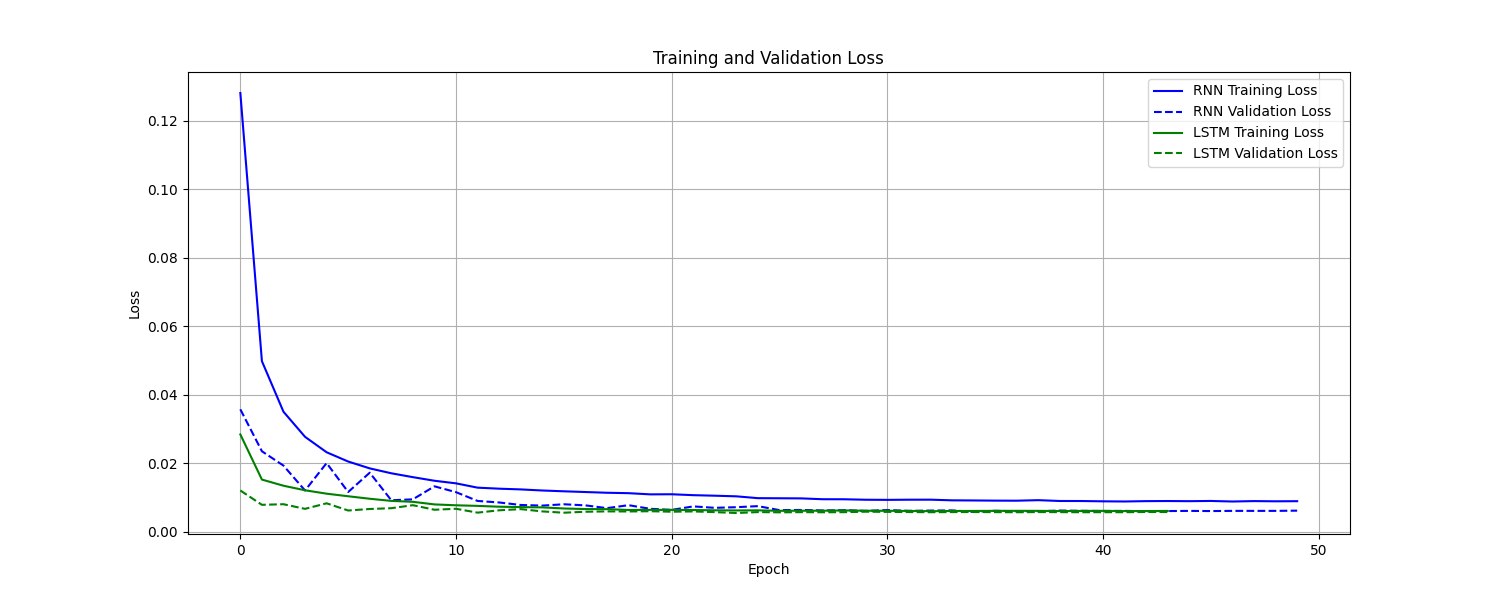

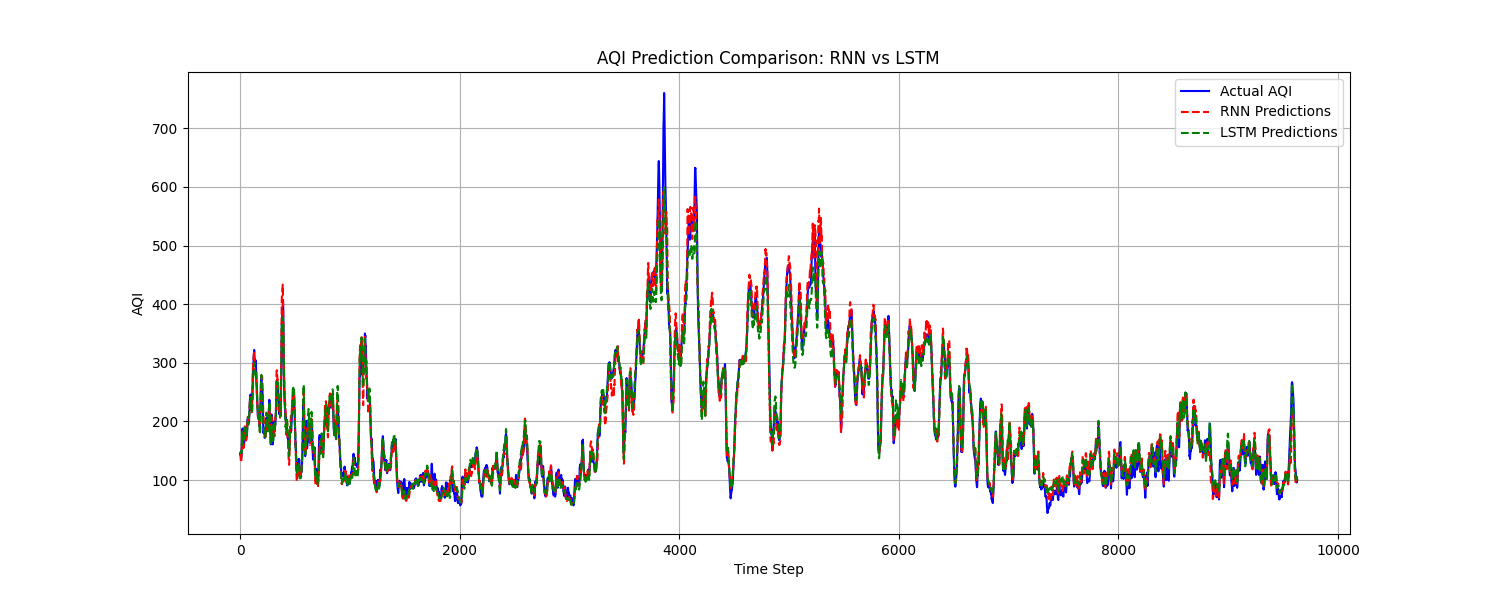